In [117]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np

In [118]:
loan_data_preprocessed_backup = pd.read_csv('loan_data_2007_2014_preprocessed.csv')

# Dependent Variable

In [119]:
loan_data_default = loan_data_preprocessed_backup.copy()

In [120]:
loan_data_default['loan_status'].value_counts(dropna= False)

Current                                                224226
Fully Paid                                             184739
Charged Off                                             42475
Late (31-120 days)                                       6900
In Grace Period                                          3146
Does not meet the credit policy. Status:Fully Paid       1988
Late (16-30 days)                                        1218
Default                                                   832
Does not meet the credit policy. Status:Charged Off       761
Name: loan_status, dtype: int64

Note: 

- We will subset our data set and take only those observations where Charge-off occurred and some time had passed for the bank to obtain recoveries

In [121]:
loan_data_default = loan_data_default[loan_data_default['loan_status'].isin(['Charged Off','Does not meet the credit policy. Status:Charged Off'])]

In [122]:
print(loan_data_default.shape)
loan_data_default.head()

(43236, 209)


,Unnamed: 0.1,Unnamed: 0,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,...,addr_state:UT,addr_state:VA,addr_state:VT,addr_state:WA,addr_state:WI,addr_state:WV,addr_state:WY,initial_list_status:f,initial_list_status:w,good_bad
1,1,1,1077430,1314167,2500,2500,2500.0,60 months,15.27,59.83,...,0,0,0,0,0,0,0,1,0,0
8,8,8,1071795,1306957,5600,5600,5600.0,60 months,21.28,152.39,...,0,0,0,0,0,0,0,1,0,0
9,9,9,1071570,1306721,5375,5375,5350.0,60 months,12.69,121.45,...,0,0,0,0,0,0,0,1,0,0
12,12,12,1064687,1298717,9000,9000,9000.0,36 months,13.49,305.38,...,0,1,0,0,0,0,0,1,0,0
14,14,14,1069057,1303503,10000,10000,10000.0,36 months,10.65,325.74,...,0,0,0,0,0,0,0,1,0,0


**Loss Given Default**: Its the portion of amount that's lost once the borrower has defaulted. Once the loan cycle starts, its defficult to predict this proportion of amount that will be lost cause we don't know if the borrower will default. But, we can predict the recovery rate that's recoveries/ funnded amount. And then, LGD is 1-recovery rate 

In [123]:
loan_data_default['Recovery Rate'] = loan_data_default['recoveries']/loan_data_default['funded_amnt']

In [124]:
loan_data_default['Recovery Rate'].describe()

count    43236.000000
mean         0.060820
std          0.089770
min          0.000000
25%          0.000000
50%          0.029466
75%          0.114044
max          1.220774
Name: Recovery Rate, dtype: float64

In [125]:
loan_data_default['Recovery Rate'] = np.where(loan_data_default['Recovery Rate'] >1,1,loan_data_default['Recovery Rate'])
loan_data_default['Recovery Rate'] = np.where(loan_data_default['Recovery Rate'] <0,0,loan_data_default['Recovery Rate'])

In [126]:
loan_data_default['Recovery Rate'].describe()

count    43236.000000
mean         0.060770
std          0.089202
min          0.000000
25%          0.000000
50%          0.029466
75%          0.114044
max          1.000000
Name: Recovery Rate, dtype: float64

(array([2.1023e+04, 1.8370e+03, 3.8730e+03, 1.3940e+03, 2.1330e+03,
        3.3440e+03, 4.7650e+03, 1.7130e+03, 1.1790e+03, 4.0600e+02,
        3.4100e+02, 2.7400e+02, 1.1700e+02, 9.3000e+01, 8.1000e+01,
        7.3000e+01, 5.4000e+01, 7.2000e+01, 5.7000e+01, 3.0000e+01,
        4.7000e+01, 2.7000e+01, 1.7000e+01, 1.5000e+01, 2.0000e+01,
        2.3000e+01, 1.7000e+01, 7.0000e+00, 1.1000e+01, 7.0000e+00,
        8.0000e+00, 7.0000e+00, 7.0000e+00, 8.0000e+00, 7.0000e+00,
        1.0000e+01, 6.0000e+00, 1.1000e+01, 9.0000e+00, 9.0000e+00,
        6.0000e+00, 6.0000e+00, 6.0000e+00, 3.0000e+00, 9.0000e+00,
        9.0000e+00, 1.5000e+01, 8.0000e+00, 9.0000e+00, 3.3000e+01]),
 array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ,
        0.22, 0.24, 0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 , 0.42,
        0.44, 0.46, 0.48, 0.5 , 0.52, 0.54, 0.56, 0.58, 0.6 , 0.62, 0.64,
        0.66, 0.68, 0.7 , 0.72, 0.74, 0.76, 0.78, 0.8 , 0.82, 0.84, 0.86,
        0.88, 0.9 , 0.

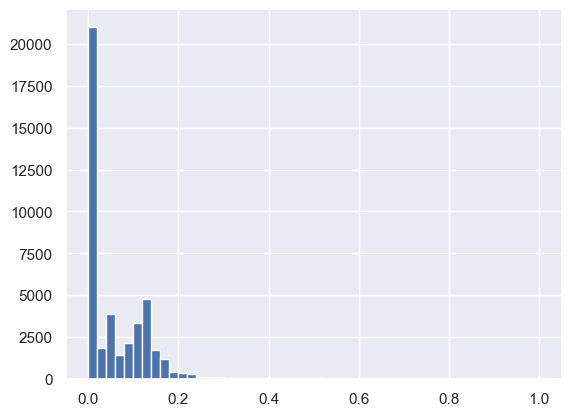

In [127]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()


plt.hist(loan_data_default['Recovery Rate'], bins = 50)

Note: Since majority of loans have recovery rate 0, we will devide our approach into two stages:

Stage 1: Logistics Regression to predict recovery rate is 0 or not 0 

Stage 2: Linear Regression to predict the actual recovery rate

# Stage 1: Logistics Regression

In [128]:
loan_data_default['Recovery Rate Flag'] = np.where(loan_data_default['Recovery Rate'] == 0,0,1)

In [129]:
loan_data_default['Recovery Rate Flag'].value_counts(dropna= False)

1    24371
0    18865
Name: Recovery Rate Flag, dtype: int64

In [130]:
loan_data_default['Recovery Rate'].value_counts(dropna= False)

0.000000    18865
1.000000       31
0.057500        7
0.046400        6
0.044000        5
            ...  
0.088741        1
0.018367        1
0.000622        1
0.084757        1
0.136000        1
Name: Recovery Rate, Length: 23828, dtype: int64

## Data Preparation Train & Test

In [131]:
from sklearn.model_selection import train_test_split

lgd_inputs_stage_1_train, lgd_inputs_stage_1_test, lgd_targets_stage_1_train,lgd_targets_stage_1_test = train_test_split(loan_data_default.drop(columns = ['good_bad','Recovery Rate','Recovery Rate Flag'],axis = 1)
                                                                                                                         ,loan_data_default['Recovery Rate Flag'],test_size= 0.2,random_state=42)

### Train Data Preparation

In [132]:
print(lgd_inputs_stage_1_train.shape)
lgd_inputs_stage_1_train.head()

(34588, 208)


,Unnamed: 0.1,Unnamed: 0,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,...,addr_state:TX,addr_state:UT,addr_state:VA,addr_state:VT,addr_state:WA,addr_state:WI,addr_state:WV,addr_state:WY,initial_list_status:f,initial_list_status:w
165859,165859,165859,3108794,3781392,13550,13550,13550.0,36 months,18.49,493.21,...,0,0,0,0,0,0,0,0,0,1
213563,213563,213563,1344077,1588657,3000,3000,3000.0,36 months,14.65,103.49,...,0,0,0,0,0,0,0,0,1,0
182682,182682,182682,2284984,2707166,3500,3500,3500.0,36 months,17.77,126.13,...,0,0,0,0,1,0,0,0,1,0
81769,81769,81769,7629442,9311362,6625,6625,6625.0,36 months,17.10,236.53,...,0,0,0,0,0,0,0,0,0,1
74862,74862,74862,8136079,9878144,18450,18450,18450.0,60 months,21.70,506.43,...,0,0,0,0,0,0,0,0,1,0


In [133]:
lgd_inputs_stage_1_prep = lgd_inputs_stage_1_train.copy()

In [134]:
lgd_inputs_stage_1_prep.columns.values

array(['Unnamed: 0.1', 'Unnamed: 0', 'id', 'member_id', 'loan_amnt',
       'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate',
       'installment', 'grade', 'sub_grade', 'emp_title', 'emp_length',
       'home_ownership', 'annual_inc', 'verification_status', 'issue_d',
       'loan_status', 'pymnt_plan', 'url', 'desc', 'purpose', 'title',
       'zip_code', 'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line',
       'inq_last_6mths', 'mths_since_last_delinq',
       'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal',
       'revol_util', 'total_acc', 'initial_list_status', 'out_prncp',
       'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv',
       'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee',
       'recoveries', 'collection_recovery_fee', 'last_pymnt_d',
       'last_pymnt_amnt', 'next_pymnt_d', 'last_credit_pull_d',
       'collections_12_mths_ex_med', 'mths_since_last_major_derog',
       'policy_code', 'application_type', 'annual_inc_joint', 'dti_join

In [135]:
features_to_consider =[
'grade:A',
'grade:B',
'grade:C',
'grade:D',
'grade:E',
'grade:F',
'grade:G',
'home_ownership:MORTGAGE',
'home_ownership:NONE',
'home_ownership:OTHER',
'home_ownership:OWN',
'home_ownership:RENT',
'verification_status:Not Verified',
'verification_status:Source Verified',
'verification_status:Verified',
'purpose:car',
'purpose:credit_card',
'purpose:debt_consolidation',
'purpose:educational',
'purpose:home_improvement',
'purpose:house',
'purpose:major_purchase',
'purpose:medical',
'purpose:moving',
'purpose:other',
'purpose:renewable_energy',
'purpose:small_business',
'purpose:vacation',
'purpose:wedding',
'initial_list_status:f',
'initial_list_status:w',
'term_int',
'emp_length_int',
'mths_since_issue_d',
'mths_since_earliest_cr_line',
'funded_amnt',
'int_rate',
'installment',
'annual_inc',
'dti',
'delinq_2yrs',
'inq_last_6mths',
'mths_since_last_delinq',
'mths_since_last_record',
'open_acc',
'pub_rec',
'total_acc',
'acc_now_delinq',
'total_rev_hi_lim'
]

In [136]:
features_reference_cat = ['grade:G',
'home_ownership:RENT',
'verification_status:Verified',
'purpose:credit_card',
'initial_list_status:f']

In [137]:
lgd_inputs_stage_1_prep = lgd_inputs_stage_1_prep[features_to_consider]

In [138]:
lgd_inputs_stage_1_prep.drop(columns=features_reference_cat, inplace= True)

In [139]:
lgd_inputs_stage_1_prep.drop(columns='funded_amnt', inplace= True)

In [140]:
print(lgd_inputs_stage_1_prep.shape)
lgd_inputs_stage_1_prep.head()

(34588, 43)


,grade:A,grade:B,grade:C,grade:D,grade:E,grade:F,home_ownership:MORTGAGE,home_ownership:NONE,home_ownership:OTHER,home_ownership:OWN,...,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,total_acc,acc_now_delinq,total_rev_hi_lim
165859,0,0,0,1,0,0,0,0,0,0,...,26.31,0.0,2.0,NaN,NaN,17.0,0.0,34.0,0.0,13700.0
213563,0,0,1,0,0,0,0,0,0,0,...,27.21,0.0,3.0,NaN,NaN,11.0,0.0,13.0,0.0,3000.0
182682,0,0,0,1,0,0,0,0,0,0,...,20.33,0.0,1.0,NaN,NaN,7.0,0.0,38.0,0.0,14600.0
81769,0,0,1,0,0,0,1,0,0,0,...,17.31,0.0,0.0,NaN,68.0,12.0,2.0,30.0,0.0,5800.0
74862,0,0,0,0,1,0,0,0,0,0,...,24.28,0.0,0.0,72.0,NaN,13.0,0.0,35.0,0.0,15900.0


In [141]:
# Checking constant columns

constant_columns = []

for cols in lgd_inputs_stage_1_prep.columns:
    if lgd_inputs_stage_1_prep[cols].nunique() == 1:
        constant_columns.append(cols)
        
print('Number of Constant Columns :',len(constant_columns))
print(constant_columns)


Number of Constant Columns : 0
[]


In [142]:
lgd_inputs_stage_1_prep['dti'].isna().sum()

0

In [143]:
# Handling NAs

variables = [ cols for cols in lgd_inputs_stage_1_prep.columns]
NA_cols = []

for cols in lgd_inputs_stage_1_prep.columns:
    NA_cols.append(lgd_inputs_stage_1_prep[cols].isna().sum())

na_summary = pd.DataFrame({
    'Variables': variables,
    '#NA': NA_cols
}
)
na_summary['%NAs'] = (na_summary['#NA']/lgd_inputs_stage_1_prep.shape[0])*100

na_summary

,Variables,#NA,%NAs
0,grade:A,0,0.000000
1,grade:B,0,0.000000
2,grade:C,0,0.000000
3,grade:D,0,0.000000
4,grade:E,0,0.000000
5,grade:F,0,0.000000
6,home_ownership:MORTGAGE,0,0.000000
7,home_ownership:NONE,0,0.000000
8,home_ownership:OTHER,0,0.000000
9,home_ownership:OWN,0,0.000000


In [144]:
# Drop NA columns:

lgd_inputs_stage_1_prep.drop(columns= ['mths_since_last_delinq','mths_since_last_record'], inplace= True)

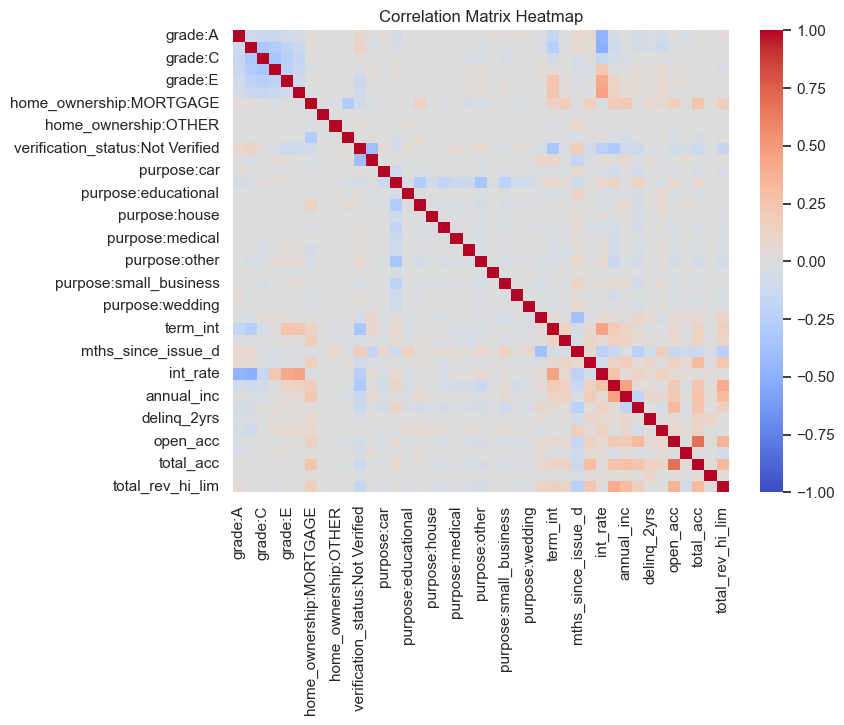

,Variable 1,Variable 2,Correlation
0,grade:A,grade:B,-0.130825
1,grade:A,grade:C,-0.155458
2,grade:A,grade:D,-0.136761
3,grade:A,grade:E,-0.099269
4,grade:A,grade:F,-0.065961
...,...,...,...
815,pub_rec,acc_now_delinq,0.000407
816,pub_rec,total_rev_hi_lim,-0.065671
817,total_acc,acc_now_delinq,0.031479
818,total_acc,total_rev_hi_lim,0.312754


In [145]:
# Checking Multicollinearity


import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the correlation matrix
correlation_matrix = lgd_inputs_stage_1_prep.corr()

# Create a heatmap for the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix Heatmap')
plt.show()

# Convert the correlation matrix to a DataFrame with variables and correlation values
correlation_values = correlation_matrix.stack().reset_index()
correlation_values.columns = ['Variable 1', 'Variable 2', 'Correlation']
# Filter out self-correlations (1.0) and duplicate pairs
correlation_values = correlation_values[correlation_values['Variable 1'] != correlation_values['Variable 2']]
correlation_values = correlation_values.drop_duplicates(subset=['Correlation']).reset_index(drop=True)

# Display the correlation values data frame
correlation_values

In [146]:
correlation_values[(correlation_values['Correlation'] > 0.75) | (correlation_values['Correlation'] < -0.75) ]

,Variable 1,Variable 2,Correlation


In [147]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# Add a constant column for intercept in the VIF calculation
X = add_constant(lgd_inputs_stage_1_prep)

# Calculate VIF for each variable
vif_data = pd.DataFrame({
    'Variable': X.columns,
    'VIF Value': [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
})

# Remove the constant from the VIF dataframe
vif_data = vif_data[vif_data['Variable'] != 'const']

# Display the VIF values
vif_data

,Variable,VIF Value
1,grade:A,12.800563
2,grade:B,25.726951
3,grade:C,22.659471
4,grade:D,15.342118
5,grade:E,8.432469
6,grade:F,4.321532
7,home_ownership:MORTGAGE,1.290459
8,home_ownership:NONE,1.001203
9,home_ownership:OTHER,1.008961
10,home_ownership:OWN,1.105695


Note: Interest Rate and Grades are very important variables, so we won't drop them

In [148]:
X_train_stage_1 = lgd_inputs_stage_1_prep

In [149]:
print(X_train_stage_1.shape)
X_train_stage_1.head()

(34588, 41)


,grade:A,grade:B,grade:C,grade:D,grade:E,grade:F,home_ownership:MORTGAGE,home_ownership:NONE,home_ownership:OTHER,home_ownership:OWN,...,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,total_acc,acc_now_delinq,total_rev_hi_lim
165859,0,0,0,1,0,0,0,0,0,0,...,493.21,38000.0,26.31,0.0,2.0,17.0,0.0,34.0,0.0,13700.0
213563,0,0,1,0,0,0,0,0,0,0,...,103.49,40000.0,27.21,0.0,3.0,11.0,0.0,13.0,0.0,3000.0
182682,0,0,0,1,0,0,0,0,0,0,...,126.13,53000.0,20.33,0.0,1.0,7.0,0.0,38.0,0.0,14600.0
81769,0,0,1,0,0,0,1,0,0,0,...,236.53,42000.0,17.31,0.0,0.0,12.0,2.0,30.0,0.0,5800.0
74862,0,0,0,0,1,0,0,0,0,0,...,506.43,69000.0,24.28,0.0,0.0,13.0,0.0,35.0,0.0,15900.0


In [150]:
y_train_stage_1 = lgd_targets_stage_1_train

In [151]:
print(y_train_stage_1.shape)
y_train_stage_1.head()

(34588,)


165859    1
213563    1
182682    1
81769     0
74862     0
Name: Recovery Rate Flag, dtype: int64

### Test Data Preparation

In [152]:
print(lgd_inputs_stage_1_test.shape)
lgd_inputs_stage_1_test.head()

(8648, 208)


,Unnamed: 0.1,Unnamed: 0,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,...,addr_state:TX,addr_state:UT,addr_state:VA,addr_state:VT,addr_state:WA,addr_state:WI,addr_state:WV,addr_state:WY,initial_list_status:f,initial_list_status:w
178928,178928,178928,2382805,2845549,10100,10100,10100.0,36 months,18.49,367.63,...,0,0,0,0,0,0,0,0,0,1
69814,69814,69814,8597067,10349097,9000,9000,8950.0,36 months,7.90,281.62,...,0,0,0,0,0,0,0,0,1,0
101396,101396,101396,6715387,8317631,6000,6000,5950.0,60 months,24.50,174.36,...,0,0,0,0,0,0,0,0,1,0
463268,463268,463268,10111118,11962523,19550,19550,19525.0,36 months,7.62,609.21,...,0,0,0,0,0,0,0,0,1,0
253729,253729,253729,34423403,37086751,18650,18650,18650.0,36 months,15.99,655.59,...,0,0,0,0,0,0,0,0,1,0


In [153]:
lgd_inputs_stage_1_prep = lgd_inputs_stage_1_test.copy()

In [154]:
lgd_inputs_stage_1_prep.columns.values

array(['Unnamed: 0.1', 'Unnamed: 0', 'id', 'member_id', 'loan_amnt',
       'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate',
       'installment', 'grade', 'sub_grade', 'emp_title', 'emp_length',
       'home_ownership', 'annual_inc', 'verification_status', 'issue_d',
       'loan_status', 'pymnt_plan', 'url', 'desc', 'purpose', 'title',
       'zip_code', 'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line',
       'inq_last_6mths', 'mths_since_last_delinq',
       'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal',
       'revol_util', 'total_acc', 'initial_list_status', 'out_prncp',
       'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv',
       'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee',
       'recoveries', 'collection_recovery_fee', 'last_pymnt_d',
       'last_pymnt_amnt', 'next_pymnt_d', 'last_credit_pull_d',
       'collections_12_mths_ex_med', 'mths_since_last_major_derog',
       'policy_code', 'application_type', 'annual_inc_joint', 'dti_join

In [155]:
features_to_consider =[
'grade:A',
'grade:B',
'grade:C',
'grade:D',
'grade:E',
'grade:F',
'grade:G',
'home_ownership:MORTGAGE',
'home_ownership:NONE',
'home_ownership:OTHER',
'home_ownership:OWN',
'home_ownership:RENT',
'verification_status:Not Verified',
'verification_status:Source Verified',
'verification_status:Verified',
'purpose:car',
'purpose:credit_card',
'purpose:debt_consolidation',
'purpose:educational',
'purpose:home_improvement',
'purpose:house',
'purpose:major_purchase',
'purpose:medical',
'purpose:moving',
'purpose:other',
'purpose:renewable_energy',
'purpose:small_business',
'purpose:vacation',
'purpose:wedding',
'initial_list_status:f',
'initial_list_status:w',
'term_int',
'emp_length_int',
'mths_since_issue_d',
'mths_since_earliest_cr_line',
'funded_amnt',
'int_rate',
'installment',
'annual_inc',
'dti',
'delinq_2yrs',
'inq_last_6mths',
'mths_since_last_delinq',
'mths_since_last_record',
'open_acc',
'pub_rec',
'total_acc',
'acc_now_delinq',
'total_rev_hi_lim'
]

In [156]:
features_reference_cat = ['grade:G',
'home_ownership:RENT',
'verification_status:Verified',
'purpose:credit_card',
'initial_list_status:f']

In [157]:
lgd_inputs_stage_1_prep = lgd_inputs_stage_1_prep[features_to_consider]

In [158]:
lgd_inputs_stage_1_prep.drop(columns=features_reference_cat, inplace= True)

In [159]:
lgd_inputs_stage_1_prep.drop(columns='funded_amnt', inplace= True)

In [160]:
print(lgd_inputs_stage_1_prep.shape)
lgd_inputs_stage_1_prep.head()

(8648, 43)


,grade:A,grade:B,grade:C,grade:D,grade:E,grade:F,home_ownership:MORTGAGE,home_ownership:NONE,home_ownership:OTHER,home_ownership:OWN,...,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,total_acc,acc_now_delinq,total_rev_hi_lim
178928,0,0,0,1,0,0,1,0,0,0,...,21.69,0.0,3.0,54.0,NaN,10.0,0.0,25.0,0.0,8400.0
69814,1,0,0,0,0,0,0,0,0,0,...,7.75,0.0,0.0,NaN,NaN,5.0,0.0,9.0,0.0,5600.0
101396,0,0,0,0,0,1,0,0,0,0,...,21.99,1.0,0.0,12.0,97.0,9.0,1.0,16.0,0.0,21900.0
463268,1,0,0,0,0,0,0,0,0,0,...,12.45,0.0,0.0,NaN,NaN,12.0,0.0,27.0,0.0,20100.0
253729,0,0,0,1,0,0,0,0,0,1,...,19.51,0.0,2.0,36.0,NaN,20.0,0.0,32.0,0.0,80400.0


In [161]:
# Checking constant columns

constant_columns = []

for cols in lgd_inputs_stage_1_prep.columns:
    if lgd_inputs_stage_1_prep[cols].nunique() == 1:
        constant_columns.append(cols)
        
print('Number of Constant Columns :',len(constant_columns))
print(constant_columns)


Number of Constant Columns : 0
[]


In [162]:
lgd_inputs_stage_1_prep['dti'].isna().sum()

0

In [163]:
# Handling NAs

variables = [ cols for cols in lgd_inputs_stage_1_prep.columns]
NA_cols = []

for cols in lgd_inputs_stage_1_prep.columns:
    NA_cols.append(lgd_inputs_stage_1_prep[cols].isna().sum())

na_summary = pd.DataFrame({
    'Variables': variables,
    '#NA': NA_cols
}
)
na_summary['%NAs'] = (na_summary['#NA']/lgd_inputs_stage_1_prep.shape[0])*100

na_summary

,Variables,#NA,%NAs
0,grade:A,0,0.000000
1,grade:B,0,0.000000
2,grade:C,0,0.000000
3,grade:D,0,0.000000
4,grade:E,0,0.000000
5,grade:F,0,0.000000
6,home_ownership:MORTGAGE,0,0.000000
7,home_ownership:NONE,0,0.000000
8,home_ownership:OTHER,0,0.000000
9,home_ownership:OWN,0,0.000000


In [164]:
# Drop NA columns:

lgd_inputs_stage_1_prep.drop(columns= ['mths_since_last_delinq','mths_since_last_record'], inplace= True)

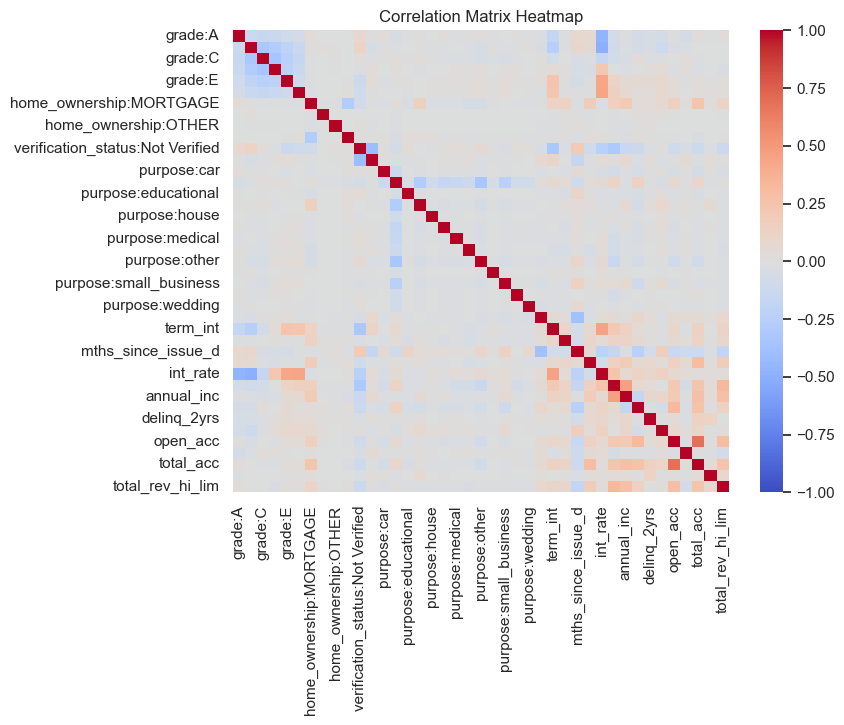

,Variable 1,Variable 2,Correlation
0,grade:A,grade:B,-0.127338
1,grade:A,grade:C,-0.154630
2,grade:A,grade:D,-0.134947
3,grade:A,grade:E,-0.097399
4,grade:A,grade:F,-0.063139
...,...,...,...
814,pub_rec,acc_now_delinq,-0.011798
815,pub_rec,total_rev_hi_lim,-0.068948
816,total_acc,acc_now_delinq,0.038292
817,total_acc,total_rev_hi_lim,0.248227


In [165]:
# Checking Multicollinearity


import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the correlation matrix
correlation_matrix = lgd_inputs_stage_1_prep.corr()

# Create a heatmap for the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix Heatmap')
plt.show()

# Convert the correlation matrix to a DataFrame with variables and correlation values
correlation_values = correlation_matrix.stack().reset_index()
correlation_values.columns = ['Variable 1', 'Variable 2', 'Correlation']
# Filter out self-correlations (1.0) and duplicate pairs
correlation_values = correlation_values[correlation_values['Variable 1'] != correlation_values['Variable 2']]
correlation_values = correlation_values.drop_duplicates(subset=['Correlation']).reset_index(drop=True)

# Display the correlation values data frame
correlation_values

In [166]:
correlation_values[(correlation_values['Correlation'] > 0.75) | (correlation_values['Correlation'] < -0.75) ]

,Variable 1,Variable 2,Correlation


In [167]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# Add a constant column for intercept in the VIF calculation
X = add_constant(lgd_inputs_stage_1_prep)

# Calculate VIF for each variable
vif_data = pd.DataFrame({
    'Variable': X.columns,
    'VIF Value': [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
})

# Remove the constant from the VIF dataframe
vif_data = vif_data[vif_data['Variable'] != 'const']

# Display the VIF values
vif_data

,Variable,VIF Value
1,grade:A,12.373519
2,grade:B,25.138368
3,grade:C,22.608577
4,grade:D,15.034716
5,grade:E,8.146877
6,grade:F,4.069669
7,home_ownership:MORTGAGE,1.273782
8,home_ownership:NONE,1.003704
9,home_ownership:OTHER,1.003926
10,home_ownership:OWN,1.106857


Note: Interest Rate and Grades are very important variables, so we won't drop them

In [168]:
X_test_stage_1 = lgd_inputs_stage_1_prep

In [169]:
print(X_test_stage_1.shape)
X_test_stage_1.head()

(8648, 41)


,grade:A,grade:B,grade:C,grade:D,grade:E,grade:F,home_ownership:MORTGAGE,home_ownership:NONE,home_ownership:OTHER,home_ownership:OWN,...,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,total_acc,acc_now_delinq,total_rev_hi_lim
178928,0,0,0,1,0,0,1,0,0,0,...,367.63,30000.0,21.69,0.0,3.0,10.0,0.0,25.0,0.0,8400.0
69814,1,0,0,0,0,0,0,0,0,0,...,281.62,52000.0,7.75,0.0,0.0,5.0,0.0,9.0,0.0,5600.0
101396,0,0,0,0,0,1,0,0,0,0,...,174.36,67000.0,21.99,1.0,0.0,9.0,1.0,16.0,0.0,21900.0
463268,1,0,0,0,0,0,0,0,0,0,...,609.21,65478.0,12.45,0.0,0.0,12.0,0.0,27.0,0.0,20100.0
253729,0,0,0,1,0,0,0,0,0,1,...,655.59,65000.0,19.51,0.0,2.0,20.0,0.0,32.0,0.0,80400.0


In [170]:
y_test_stage_1 = lgd_targets_stage_1_test

In [171]:
print(y_test_stage_1.shape)
y_test_stage_1.head()

(8648,)


178928    1
69814     1
101396    0
463268    1
253729    0
Name: Recovery Rate Flag, dtype: int64

## Model Development

### Stats Model : Filter Significant columns / Relevant columns

In [172]:
import statsmodels.api as sm
from sklearn.metrics import accuracy_score


# Fit the logistic regression model
logit_model = sm.Logit(y_train_stage_1, X_train_stage_1)
result = logit_model.fit()

# Print the summary of the model
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.630872
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:     Recovery Rate Flag   No. Observations:                34588
Model:                          Logit   Df Residuals:                    34547
Method:                           MLE   Df Model:                           40
Date:                Thu, 14 Nov 2024   Pseudo R-squ.:                 0.07915
Time:                        22:04:45   Log-Likelihood:                -21821.
converged:                       True   LL-Null:                       -23696.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
grade:A                                -0.6012      0.082 

In [173]:
insignificant_columns_to_drop = [
    'home_ownership:MORTGAGE',
    'home_ownership:NONE',
    'home_ownership:OTHER',
    'home_ownership:OWN',
    'emp_length_int',
    'delinq_2yrs',
    'open_acc',
    'acc_now_delinq'
]

In [174]:
X_train_stage_1.drop(columns=insignificant_columns_to_drop, inplace= True)

In [175]:
X_test_stage_1.drop(columns=insignificant_columns_to_drop, inplace= True)

In [176]:
import statsmodels.api as sm
from sklearn.metrics import accuracy_score


# Fit the logistic regression model
logit_model = sm.Logit(y_train_stage_1, X_train_stage_1)
result = logit_model.fit()

# Print the summary of the model
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.631041
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:     Recovery Rate Flag   No. Observations:                34588
Model:                          Logit   Df Residuals:                    34555
Method:                           MLE   Df Model:                           32
Date:                Thu, 14 Nov 2024   Pseudo R-squ.:                 0.07891
Time:                        22:04:45   Log-Likelihood:                -21826.
converged:                       True   LL-Null:                       -23696.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
grade:A                                -0.6044      0.082 

### Determining the initial cut-off to predict recovery rate flag = 1

In [177]:
# Predict on the test set
y_pred_prob_stage_1 = result.predict(X_test_stage_1)

ks_data = pd.DataFrame({
        'predicted_proba': y_pred_prob_stage_1,
        'actual': y_test_stage_1.squeeze()
    })

ks_data = ks_data.sort_values(by='predicted_proba', ascending=False).reset_index(drop=True)

ks_data['predicted_group'] = pd.qcut(ks_data['predicted_proba'], q=10, labels=False) + 1


# Aggregate data for KS table
ks_table = ks_data.groupby('predicted_group').apply(
    lambda x: pd.Series({
        'Total Apps': len(x),
        'Recovery is 0': len(x[x['actual'] == 0]),
        'Recovery is 1': len(x[x['actual'] == 1]),
        'Minimum Predicted': x['predicted_proba'].min(),
        'Maximum Predicted': x['predicted_proba'].max(),
        'Average Predicted': x['predicted_proba'].mean(),
        'Average Actual': x['actual'].mean(),
        'Error Rate': x['predicted_proba'].mean() - x['actual'].mean()
    })
).reset_index()

# Calculate cumulative percentages
ks_table['Recovery is 0 %'] = (ks_table['Recovery is 0'] / ks_table['Recovery is 0'].sum()) * 100
ks_table['Recovery is 1 %'] = (ks_table['Recovery is 1'] / ks_table['Recovery is 1'].sum()) * 100
ks_table['Cumulative Recovery is 0 %'] = ks_table['Recovery is 0 %'].cumsum()
ks_table['Cumulative Recovery is 1 %'] = ks_table['Recovery is 1 %'].cumsum()

# Create a Predicted Proba Range column combining Minimum and Maximum Predicted values
ks_table['Predicted_Proba_Range'] = ks_table['Minimum Predicted'].round(3).astype(str) + " - " + ks_table['Maximum Predicted'].round(3).astype(str)

In [178]:
ks_table

,predicted_group,Total Apps,Recovery is 0,Recovery is 1,Minimum Predicted,Maximum Predicted,Average Predicted,Average Actual,Error Rate,Recovery is 0 %,Recovery is 1 %,Cumulative Recovery is 0 %,Cumulative Recovery is 1 %,Predicted_Proba_Range
0,1,865.0,617.0,248.0,0.141236,0.321220,0.275638,0.286705,-0.011067,16.400851,5.075727,16.400851,5.075727,0.141 - 0.321
1,2,865.0,528.0,337.0,0.321298,0.405949,0.363317,0.389595,-0.026279,14.035088,6.897257,30.435938,11.972984,0.321 - 0.406
2,3,865.0,509.0,356.0,0.405954,0.492112,0.451137,0.411561,0.039577,13.530037,7.286124,43.965976,19.259108,0.406 - 0.492
3,4,864.0,450.0,414.0,0.492191,0.547923,0.520655,0.479167,0.041488,11.961722,8.473189,55.927698,27.732296,0.492 - 0.548
4,5,865.0,384.0,481.0,0.548024,0.587456,0.568273,0.556069,0.012203,10.207337,9.844454,66.135035,37.576750,0.548 - 0.587
5,6,865.0,343.0,522.0,0.587494,0.623518,0.605215,0.603468,0.001746,9.117491,10.683586,75.252525,48.260336,0.587 - 0.624
6,7,864.0,295.0,569.0,0.623563,0.659352,0.641283,0.658565,-0.017282,7.841574,11.645518,83.094099,59.905853,0.624 - 0.659
7,8,865.0,245.0,620.0,0.659386,0.700423,0.678971,0.716763,-0.037792,6.512493,12.689316,89.606592,72.595170,0.659 - 0.7
8,9,865.0,191.0,674.0,0.700425,0.755201,0.726424,0.779191,-0.052767,5.077087,13.794515,94.683679,86.389685,0.7 - 0.755
9,10,865.0,200.0,665.0,0.755395,0.957656,0.813477,0.768786,0.044691,5.316321,13.610315,100.000000,100.000000,0.755 - 0.958


Note: Since almost 50% of all the Recovery Rate = 1, are at 0.587 probability. We keep the cut-off as 0.587

### Sklear: logistics Regression Model

In [179]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


# Initialize and train the logistic regression model
model = LogisticRegression()
model.fit(X_train_stage_1, y_train_stage_1)

# Make predictions
y_pred = model.predict(X_test_stage_1)

# Predict probabilities
y_probs = model.predict_proba(X_test_stage_1)[:, 1]  # Get probabilities for the positive class

# Set custom cut-off threshold
cut_off = 0.587
y_pred_custom_stage_1 = (y_probs >= cut_off).astype(int)  # Apply cut-off

# Evaluate the model
accuracy = accuracy_score(y_test_stage_1, y_pred_custom_stage_1)
conf_matrix = confusion_matrix(y_test_stage_1, y_pred_custom_stage_1)
class_report = classification_report(y_test_stage_1, y_pred_custom_stage_1)

print(f'Accuracy: {accuracy:.2f}')
print('Confusion Matrix:')
print(conf_matrix)
print('Classification Report:')
print(class_report)

Accuracy: 0.60
Confusion Matrix:
[[2640 1122]
 [2363 2523]]
Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.70      0.60      3762
           1       0.69      0.52      0.59      4886

    accuracy                           0.60      8648
   macro avg       0.61      0.61      0.60      8648
weighted avg       0.62      0.60      0.60      8648



In [180]:
from sklearn.metrics import balanced_accuracy_score

# Assuming y_true and y_pred are your true and predicted labels
balanced_acc = balanced_accuracy_score(y_test_stage_1, y_pred_custom_stage_1)
print(f'Balanced Accuracy: {balanced_acc:.2f}')

Balanced Accuracy: 0.61


### Model Evaluation

#### ROC-AUC

ROC AUC Score: 0.61


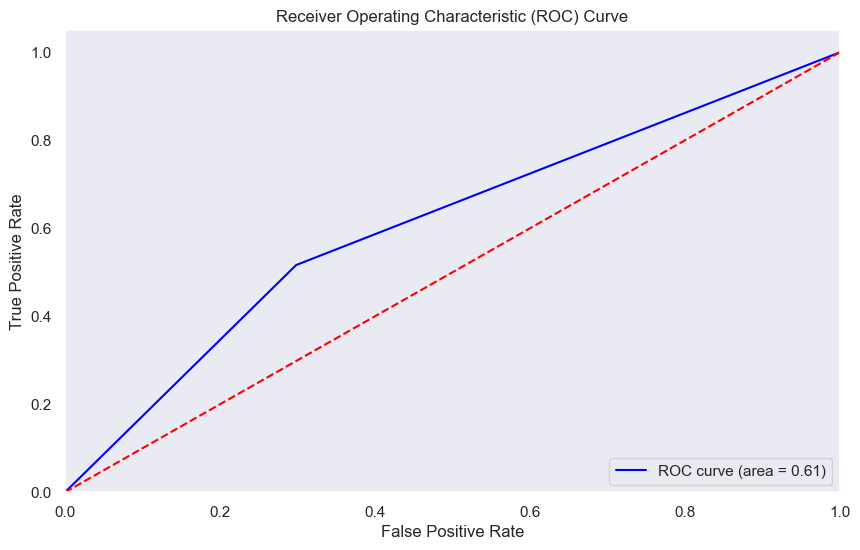

In [181]:
from sklearn.metrics import roc_curve, auc,roc_auc_score
import matplotlib.pyplot as plt

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test_stage_1, y_pred_custom_stage_1)
print(f'ROC AUC Score: {roc_auc:.2f}')

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test_stage_1,y_pred_custom_stage_1)

# Calculate AUC
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line (random guess)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

#### Gini Index

In [182]:
validation_df = pd.DataFrame({
        'predicted_proba': y_pred_prob_stage_1,
        'actual': y_test_stage_1.squeeze()
    })

validation_df['predicted'] = np.where(validation_df['predicted_proba'] >= 0.587,1,0)

validation_df = validation_df.sort_values('predicted_proba')


validation_df = validation_df.reset_index()


validation_df['Cumulative N Population'] = validation_df.index + 1
validation_df['Cumulative N Recovery 1'] = validation_df['actual'].cumsum()
validation_df['Cumulative N Recovery 0'] = validation_df['Cumulative N Population'] - validation_df['actual'].cumsum()

validation_df['Cumulative Perc Population'] = validation_df['Cumulative N Population'] / (validation_df.shape[0])
validation_df['Cumulative Perc Recovery 1'] = validation_df['Cumulative N Recovery 1'] / validation_df['actual'].sum()
validation_df['Cumulative Perc Recovery 0'] = validation_df['Cumulative N Recovery 0'] / (validation_df.shape[0] - validation_df['actual'].sum())

Gini Index :  0.21812769746716354


Text(0.5, 1.0, 'Gini')

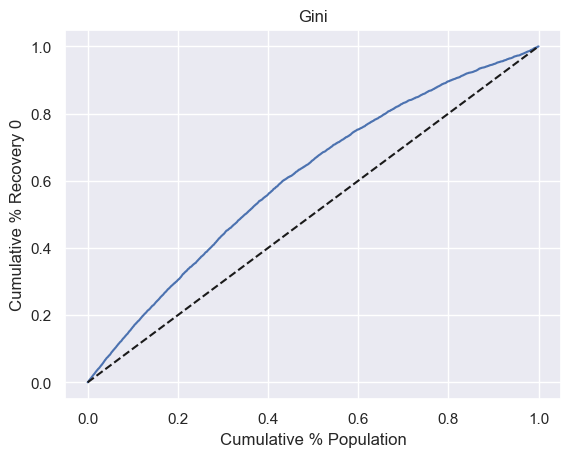

In [183]:
Gini = roc_auc * 2 - 1
print('Gini Index : ',Gini)


plt.plot(validation_df['Cumulative Perc Population'], validation_df['Cumulative Perc Recovery 0'])
plt.plot(validation_df['Cumulative Perc Population'], validation_df['Cumulative Perc Population'], linestyle = '--', color = 'k')
plt.xlabel('Cumulative % Population')
plt.ylabel('Cumulative % Recovery 0')
plt.title('Gini')

#### KS

KS statistics :  0.2960783916899133


Text(0.5, 1.0, 'Kolmogorov-Smirnov')

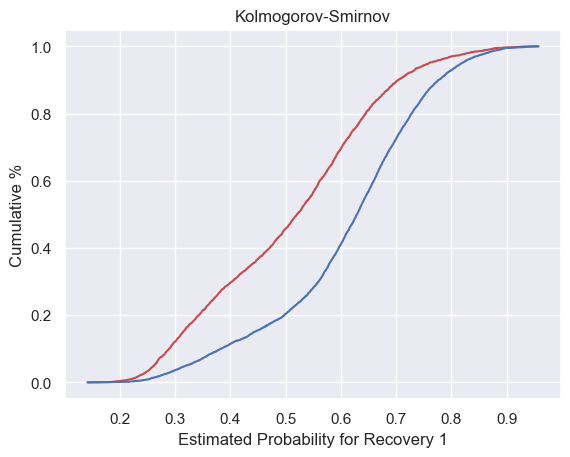

In [184]:
KS = max(validation_df['Cumulative Perc Recovery 0'] - validation_df['Cumulative Perc Recovery 1'])
print('KS statistics : ',KS)

plt.plot(validation_df['predicted_proba'], validation_df['Cumulative Perc Recovery 0'], color = 'r')
plt.plot(validation_df['predicted_proba'], validation_df['Cumulative Perc Recovery 1'], color = 'b')
plt.xlabel('Estimated Probability for Recovery 1')
plt.ylabel('Cumulative %')
plt.title('Kolmogorov-Smirnov')

In [185]:
import pickle

pickle.dump(model, open('lgd_model_stage_1.sav','wb'))

In [186]:
selected_features = X_train_stage_1.columns.to_list()

# Stage 2: Linear Regression Model

Note: Keep the same features that were present in stage 1 for better and seemless calculation of LGD

In [187]:
loan_data_default_stage2 = loan_data_default[loan_data_default['Recovery Rate Flag'] == 1]

In [188]:
print(loan_data_default_stage2.shape)
loan_data_default_stage2.head()

(24371, 211)


,Unnamed: 0.1,Unnamed: 0,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,...,addr_state:VT,addr_state:WA,addr_state:WI,addr_state:WV,addr_state:WY,initial_list_status:f,initial_list_status:w,good_bad,Recovery Rate,Recovery Rate Flag
1,1,1,1077430,1314167,2500,2500,2500.0,60 months,15.27,59.83,...,0,0,0,0,0,1,0,0,0.046832,1
8,8,8,1071795,1306957,5600,5600,5600.0,60 months,21.28,152.39,...,0,0,0,0,0,1,0,0,0.033761,1
9,9,9,1071570,1306721,5375,5375,5350.0,60 months,12.69,121.45,...,0,0,0,0,0,1,0,0,0.050100,1
12,12,12,1064687,1298717,9000,9000,9000.0,36 months,13.49,305.38,...,0,0,0,0,0,1,0,0,0.049367,1
14,14,14,1069057,1303503,10000,10000,10000.0,36 months,10.65,325.74,...,0,0,0,0,0,1,0,0,0.064510,1


## Data Preparation Train & Test

In [189]:
from sklearn.model_selection import train_test_split

lgd_inputs_stage_2_train, lgd_inputs_stage_2_test, lgd_targets_stage_2_train,lgd_targets_stage_2_test = train_test_split(loan_data_default_stage2.drop(columns = ['good_bad','Recovery Rate','Recovery Rate Flag'],axis = 1)
                                                                                                                         ,loan_data_default_stage2['Recovery Rate'],test_size= 0.2,random_state=42)

### Train Data Preparation

In [190]:
print(lgd_inputs_stage_2_train.shape)
lgd_inputs_stage_2_train.head()

(19496, 208)


,Unnamed: 0.1,Unnamed: 0,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,...,addr_state:TX,addr_state:UT,addr_state:VA,addr_state:VT,addr_state:WA,addr_state:WI,addr_state:WV,addr_state:WY,initial_list_status:f,initial_list_status:w
231132,231132,231132,37751581,40514546,23000,23000,23000.0,60 months,15.59,554.32,...,1,0,0,0,0,0,0,0,0,1
224522,224522,224522,1172006,1413161,10000,10000,10000.0,36 months,10.74,326.16,...,0,0,0,0,0,0,0,0,1,0
188577,188577,188577,1690331,1972861,7200,7200,7200.0,36 months,18.75,263.02,...,0,0,0,0,0,0,0,0,1,0
188396,188396,188396,1681667,1964284,24000,24000,24000.0,60 months,15.80,581.09,...,0,0,0,0,0,0,0,0,1,0
336956,336956,336956,22263441,24586136,30000,30000,30000.0,60 months,18.99,778.06,...,0,0,0,0,0,0,0,0,0,1


In [191]:
lgd_inputs_stage_2_prep = lgd_inputs_stage_2_train.copy()

In [192]:
lgd_inputs_stage_2_prep = lgd_inputs_stage_2_prep[selected_features]

In [193]:
print(lgd_inputs_stage_2_prep.shape)
lgd_inputs_stage_2_prep.head()

(19496, 33)


,grade:A,grade:B,grade:C,grade:D,grade:E,grade:F,verification_status:Not Verified,verification_status:Source Verified,purpose:car,purpose:debt_consolidation,...,mths_since_issue_d,mths_since_earliest_cr_line,int_rate,installment,annual_inc,dti,inq_last_6mths,pub_rec,total_acc,total_rev_hi_lim
231132,0,0,0,1,0,0,0,1,0,1,...,36.0,316.0,15.59,554.32,65000.0,35.28,0.0,0.0,42.0,40000.0
224522,0,1,0,0,0,0,0,1,0,1,...,69.0,286.0,10.74,326.16,170000.0,4.59,0.0,0.0,21.0,10000.0
188577,0,0,0,1,0,0,0,0,0,0,...,61.0,161.0,18.75,263.02,26500.0,7.11,3.0,0.0,5.0,5500.0
188396,0,0,1,0,0,0,0,0,0,1,...,61.0,256.0,15.80,581.09,120000.0,19.31,3.0,0.0,34.0,169400.0
336956,0,0,0,0,1,0,0,1,0,1,...,41.0,232.0,18.99,778.06,134000.0,15.34,4.0,1.0,33.0,33900.0


In [194]:
# Handling NAs

variables = [ cols for cols in lgd_inputs_stage_2_prep.columns]
NA_cols = []

for cols in lgd_inputs_stage_2_prep.columns:
    NA_cols.append(lgd_inputs_stage_2_prep[cols].isna().sum())

na_summary = pd.DataFrame({
    'Variables': variables,
    '#NA': NA_cols
}
)
na_summary['%NAs'] = (na_summary['#NA']/lgd_inputs_stage_2_prep.shape[0])*100

na_summary

,Variables,#NA,%NAs
0,grade:A,0,0.0
1,grade:B,0,0.0
2,grade:C,0,0.0
3,grade:D,0,0.0
4,grade:E,0,0.0
5,grade:F,0,0.0
6,verification_status:Not Verified,0,0.0
7,verification_status:Source Verified,0,0.0
8,purpose:car,0,0.0
9,purpose:debt_consolidation,0,0.0


In [195]:
X_train_stage_2 = lgd_inputs_stage_2_prep

In [196]:
print(X_train_stage_2.shape)
X_train_stage_2.head()

(19496, 33)


,grade:A,grade:B,grade:C,grade:D,grade:E,grade:F,verification_status:Not Verified,verification_status:Source Verified,purpose:car,purpose:debt_consolidation,...,mths_since_issue_d,mths_since_earliest_cr_line,int_rate,installment,annual_inc,dti,inq_last_6mths,pub_rec,total_acc,total_rev_hi_lim
231132,0,0,0,1,0,0,0,1,0,1,...,36.0,316.0,15.59,554.32,65000.0,35.28,0.0,0.0,42.0,40000.0
224522,0,1,0,0,0,0,0,1,0,1,...,69.0,286.0,10.74,326.16,170000.0,4.59,0.0,0.0,21.0,10000.0
188577,0,0,0,1,0,0,0,0,0,0,...,61.0,161.0,18.75,263.02,26500.0,7.11,3.0,0.0,5.0,5500.0
188396,0,0,1,0,0,0,0,0,0,1,...,61.0,256.0,15.80,581.09,120000.0,19.31,3.0,0.0,34.0,169400.0
336956,0,0,0,0,1,0,0,1,0,1,...,41.0,232.0,18.99,778.06,134000.0,15.34,4.0,1.0,33.0,33900.0


In [197]:
y_train_stage_2 = lgd_targets_stage_2_train

In [198]:
print(y_train_stage_2.shape)
y_train_stage_2.head()

(19496,)


231132    0.174157
224522    0.037034
188577    0.259313
188396    0.055503
336956    0.139995
Name: Recovery Rate, dtype: float64

### Test Data Preparation

In [199]:
print(lgd_inputs_stage_2_test.shape)
lgd_inputs_stage_2_test.head()

(4875, 208)


,Unnamed: 0.1,Unnamed: 0,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,...,addr_state:TX,addr_state:UT,addr_state:VA,addr_state:VT,addr_state:WA,addr_state:WI,addr_state:WV,addr_state:WY,initial_list_status:f,initial_list_status:w
221921,221921,221921,1151009,1391998,7400,7400,7400.0,36 months,9.76,237.95,...,1,0,0,0,0,0,0,0,1,0
338754,338754,338754,22432231,24765111,30000,30000,30000.0,60 months,24.50,871.77,...,0,0,0,0,0,0,0,0,0,1
45237,45237,45237,10085880,11937937,25000,25000,25000.0,60 months,20.50,669.33,...,0,0,0,0,0,0,0,0,1,0
13641,13641,13641,778997,981657,4800,4800,4800.0,60 months,17.49,120.57,...,1,0,0,0,0,0,0,0,1,0
223984,223984,223984,1179484,1420887,14675,14675,14425.0,36 months,10.74,478.64,...,0,0,0,0,0,0,0,0,1,0


In [200]:
lgd_inputs_stage_2_prep = lgd_inputs_stage_2_test.copy()

In [201]:
lgd_inputs_stage_2_prep = lgd_inputs_stage_2_prep[selected_features]

In [202]:
print(lgd_inputs_stage_2_prep.shape)
lgd_inputs_stage_2_prep.head()

(4875, 33)


,grade:A,grade:B,grade:C,grade:D,grade:E,grade:F,verification_status:Not Verified,verification_status:Source Verified,purpose:car,purpose:debt_consolidation,...,mths_since_issue_d,mths_since_earliest_cr_line,int_rate,installment,annual_inc,dti,inq_last_6mths,pub_rec,total_acc,total_rev_hi_lim
221921,0,1,0,0,0,0,1,0,0,0,...,68.0,205.0,9.76,237.95,40000.0,23.49,2.0,0.0,62.0,7400.0
338754,0,0,0,0,0,1,0,0,0,0,...,41.0,189.0,24.50,871.77,160000.0,11.22,1.0,0.0,20.0,29000.0
45237,0,0,0,0,1,0,0,1,0,1,...,48.0,140.0,20.50,669.33,60000.0,26.44,0.0,0.0,28.0,29000.0
13641,0,0,0,1,0,0,0,1,0,1,...,78.0,201.0,17.49,120.57,70248.0,23.35,1.0,0.0,28.0,4800.0
223984,0,1,0,0,0,0,0,0,0,0,...,69.0,144.0,10.74,478.64,61000.0,6.41,0.0,0.0,10.0,14675.0


In [203]:
# Handling NAs

variables = [ cols for cols in lgd_inputs_stage_2_prep.columns]
NA_cols = []

for cols in lgd_inputs_stage_2_prep.columns:
    NA_cols.append(lgd_inputs_stage_2_prep[cols].isna().sum())

na_summary = pd.DataFrame({
    'Variables': variables,
    '#NA': NA_cols
}
)
na_summary['%NAs'] = (na_summary['#NA']/lgd_inputs_stage_2_prep.shape[0])*100

na_summary

,Variables,#NA,%NAs
0,grade:A,0,0.0
1,grade:B,0,0.0
2,grade:C,0,0.0
3,grade:D,0,0.0
4,grade:E,0,0.0
5,grade:F,0,0.0
6,verification_status:Not Verified,0,0.0
7,verification_status:Source Verified,0,0.0
8,purpose:car,0,0.0
9,purpose:debt_consolidation,0,0.0


In [204]:
X_test_stage_2 = lgd_inputs_stage_2_prep

In [205]:
print(X_test_stage_2.shape)
X_test_stage_2.head()

(4875, 33)


,grade:A,grade:B,grade:C,grade:D,grade:E,grade:F,verification_status:Not Verified,verification_status:Source Verified,purpose:car,purpose:debt_consolidation,...,mths_since_issue_d,mths_since_earliest_cr_line,int_rate,installment,annual_inc,dti,inq_last_6mths,pub_rec,total_acc,total_rev_hi_lim
221921,0,1,0,0,0,0,1,0,0,0,...,68.0,205.0,9.76,237.95,40000.0,23.49,2.0,0.0,62.0,7400.0
338754,0,0,0,0,0,1,0,0,0,0,...,41.0,189.0,24.50,871.77,160000.0,11.22,1.0,0.0,20.0,29000.0
45237,0,0,0,0,1,0,0,1,0,1,...,48.0,140.0,20.50,669.33,60000.0,26.44,0.0,0.0,28.0,29000.0
13641,0,0,0,1,0,0,0,1,0,1,...,78.0,201.0,17.49,120.57,70248.0,23.35,1.0,0.0,28.0,4800.0
223984,0,1,0,0,0,0,0,0,0,0,...,69.0,144.0,10.74,478.64,61000.0,6.41,0.0,0.0,10.0,14675.0


In [206]:
y_test_stage_2 = lgd_targets_stage_2_test

In [207]:
print(y_test_stage_2.shape)
y_test_stage_2.head()

(4875,)


221921    0.033254
338754    0.156128
45237     0.181260
13641     0.035356
223984    0.046756
Name: Recovery Rate, dtype: float64

In [208]:
y_train_stage_2.shape

(19496,)

In [209]:
X_train_stage_2.shape

(19496, 33)

In [210]:
X_test_stage_2.shape

(4875, 33)

In [211]:
y_test_stage_2.shape

(4875,)

## Model Development

## OLS Model

In [212]:
X_train_stage_2 = sm.add_constant(X_train_stage_2)  # Adds a constant term to the predictor

# Fit the model
model = sm.OLS(y_train_stage_2, X_train_stage_2).fit()

# Print the summary of the regression results
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:          Recovery Rate   R-squared:                       0.089
Model:                            OLS   Adj. R-squared:                  0.087
Method:                 Least Squares   F-statistic:                     57.31
Date:                Thu, 14 Nov 2024   Prob (F-statistic):               0.00
Time:                        22:04:46   Log-Likelihood:                 19012.
No. Observations:               19496   AIC:                        -3.796e+04
Df Residuals:                   19462   BIC:                        -3.769e+04
Df Model:                          33                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
co

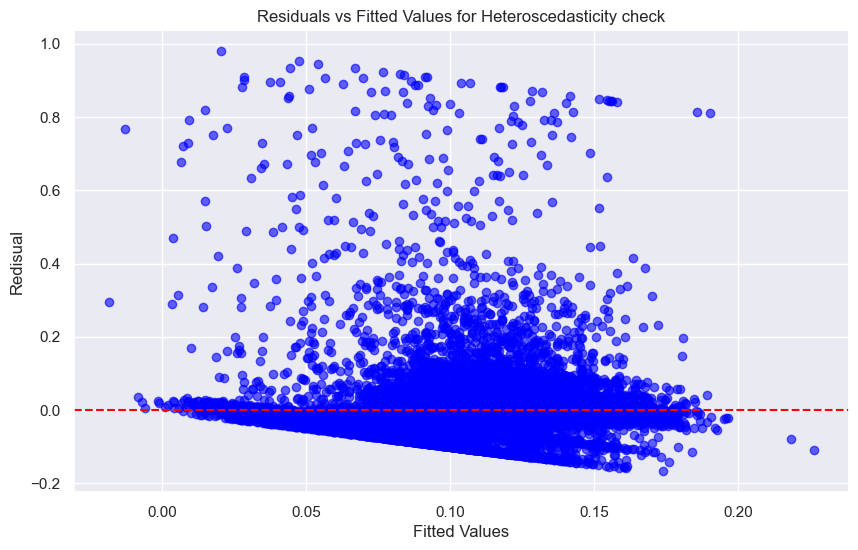

In [213]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

fitted_values = model.fittedvalues
residuals = model.resid


plt.figure(figsize = (10,6))
plt.scatter(fitted_values,residuals,color = 'blue', alpha= 0.6)
plt.axhline(y=0,color = 'red', linestyle = '--')
plt.xlabel('Fitted Values')
plt.ylabel('Redisual')
plt.title('Residuals vs Fitted Values for Heteroscedasticity check')
plt.show()

In [214]:
# Statistical test to check heteroscedasticity : Breusch-Pagan test

from statsmodels.stats.diagnostic import het_breuschpagan


# het_breuschpagan takes residuals and the independent variables as input
bp_test = het_breuschpagan(model.resid, X_train_stage_2)

# Extracting test results
bp_stat = bp_test[0]  # Breusch-Pagan statistic
p_value = bp_test[1]  # p-value for the test

print("Breusch-Pagan test statistic:", bp_stat)
print("p-value:", p_value)

# Interpretation
if p_value < 0.05:
    print("The test indicates heteroscedasticity (p-value < 0.05).")
else:
    print("The test does not indicate heteroscedasticity (p-value >= 0.05).")

Breusch-Pagan test statistic: 355.5321008088641
p-value: 9.86378793180867e-56
The test indicates heteroscedasticity (p-value < 0.05).


In [215]:
# WLS model

import statsmodels.api as sm

# Estimate weights as the inverse of residuals' variance (or any appropriate function)
weights = 1 / model.resid ** 2

# Fit WLS model
wls_model = sm.WLS(y_train_stage_2, X_train_stage_2, weights=weights).fit()


In [216]:
print(wls_model.summary())

                            WLS Regression Results                            
Dep. Variable:          Recovery Rate   R-squared:                       1.000
Model:                            WLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 7.078e+06
Date:                Thu, 14 Nov 2024   Prob (F-statistic):               0.00
Time:                        22:04:47   Log-Likelihood:                 48178.
No. Observations:               19496   AIC:                        -9.629e+04
Df Residuals:                   19462   BIC:                        -9.602e+04
Df Model:                          33                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
co

## Sklearn: Regularization technique

In [217]:
X_train_stage_2.columns

Index(['const', 'grade:A', 'grade:B', 'grade:C', 'grade:D', 'grade:E',
       'grade:F', 'verification_status:Not Verified',
       'verification_status:Source Verified', 'purpose:car',
       'purpose:debt_consolidation', 'purpose:educational',
       'purpose:home_improvement', 'purpose:house', 'purpose:major_purchase',
       'purpose:medical', 'purpose:moving', 'purpose:other',
       'purpose:renewable_energy', 'purpose:small_business',
       'purpose:vacation', 'purpose:wedding', 'initial_list_status:w',
       'term_int', 'mths_since_issue_d', 'mths_since_earliest_cr_line',
       'int_rate', 'installment', 'annual_inc', 'dti', 'inq_last_6mths',
       'pub_rec', 'total_acc', 'total_rev_hi_lim'],
      dtype='object')

In [218]:
X_train_stage_2.drop(columns='const',inplace= True)

In [219]:
# Grid Search: This will help you decide which alpha value (Lambada) will be best for the model

# Import necessary libraries
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, r2_score

# Define the model
lasso_reg = Lasso()

# Define the parameter grid
param_grid = {
    'alpha': [0.001, 0.01, 0.1, 1, 10, 100]  # List of alpha values to try
}

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=lasso_reg, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5)

# Fit GridSearchCV
grid_search.fit(X_train_stage_2, y_train_stage_2)

# Get the best parameters and model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Make predictions with the best model
y_pred_stage_2 = best_model.predict(X_test_stage_2)

# Evaluate the model
mse = mean_squared_error(y_test_stage_2, y_pred_stage_2)
r2 = r2_score(y_test_stage_2, y_pred_stage_2)

# Print the results
print("Best Parameters:", best_params)
print("Best Model's Mean Squared Error (MSE):", mse)
print("Best Model's R-squared (R2):", r2)
print("Lasso Coefficients:", best_model.coef_)


Best Parameters: {'alpha': 0.001}
Best Model's Mean Squared Error (MSE): 0.007899762178154607
Best Model's R-squared (R2): 0.0895502736014937
Lasso Coefficients: [-0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00
 -0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00
 -0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00
  0.00000000e+00  8.33349851e-03  3.25039005e-04 -1.36213023e-03
  4.34550338e-05  1.31231898e-03 -1.98321594e-05  6.88753092e-08
  1.33921761e-05  9.26394722e-04  0.00000000e+00  1.91386011e-04
  1.91251410e-07]


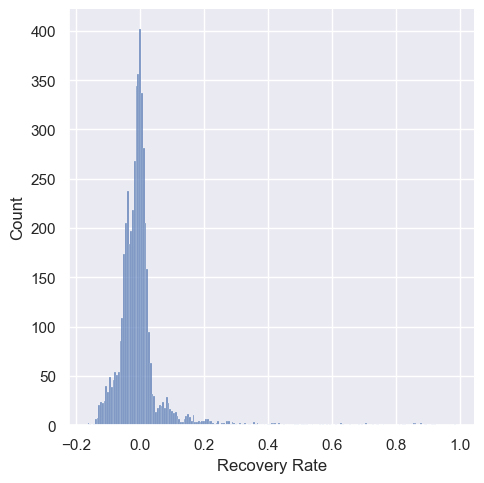

In [220]:
sns.displot(lgd_targets_stage_2_test - y_pred_stage_2)

In [221]:
import pickle

pickle.dump(best_model, open('lgd_model_stage_2.sav','wb'))

## Combining Stage 1 and Stage 2

In [222]:
X_train_stage_1.shape

(34588, 33)

In [223]:
y_train_stage_1.shape

(34588,)

In [224]:
X_train_stage_2.shape

(19496, 33)

In [225]:
y_train_stage_2.shape

(19496,)

Note: We now run our recovery rate prediction to test set from stage 1 

In [226]:
y_hat_test_lgd_stage_2_all = best_model.predict(X_test_stage_1)

In [227]:
y_hat_test_lgd = y_test_stage_1 * y_hat_test_lgd_stage_2_all

In [228]:
pd.DataFrame(y_hat_test_lgd).describe()

,Recovery Rate Flag
count,8648.000000
mean,0.061052
std,0.057379
min,-0.011689
25%,0.000000
50%,0.075602
75%,0.114932
max,0.191289


In [229]:
y_hat_test_lgd = np.where(y_hat_test_lgd < 0,0,y_hat_test_lgd)
y_hat_test_lgd = np.where(y_hat_test_lgd > 1,1,y_hat_test_lgd)

In [230]:
pd.DataFrame(y_hat_test_lgd).describe()

,0
count,8648.000000
mean,0.061054
std,0.057377
min,0.000000
25%,0.000000
50%,0.075602
75%,0.114932
max,0.191289


In [231]:
X_train_stage_1.columns.to_list()

['grade:A',
 'grade:B',
 'grade:C',
 'grade:D',
 'grade:E',
 'grade:F',
 'verification_status:Not Verified',
 'verification_status:Source Verified',
 'purpose:car',
 'purpose:debt_consolidation',
 'purpose:educational',
 'purpose:home_improvement',
 'purpose:house',
 'purpose:major_purchase',
 'purpose:medical',
 'purpose:moving',
 'purpose:other',
 'purpose:renewable_energy',
 'purpose:small_business',
 'purpose:vacation',
 'purpose:wedding',
 'initial_list_status:w',
 'term_int',
 'mths_since_issue_d',
 'mths_since_earliest_cr_line',
 'int_rate',
 'installment',
 'annual_inc',
 'dti',
 'inq_last_6mths',
 'pub_rec',
 'total_acc',
 'total_rev_hi_lim']

In [232]:
X_train_stage_2.columns.to_list()

['grade:A',
 'grade:B',
 'grade:C',
 'grade:D',
 'grade:E',
 'grade:F',
 'verification_status:Not Verified',
 'verification_status:Source Verified',
 'purpose:car',
 'purpose:debt_consolidation',
 'purpose:educational',
 'purpose:home_improvement',
 'purpose:house',
 'purpose:major_purchase',
 'purpose:medical',
 'purpose:moving',
 'purpose:other',
 'purpose:renewable_energy',
 'purpose:small_business',
 'purpose:vacation',
 'purpose:wedding',
 'initial_list_status:w',
 'term_int',
 'mths_since_issue_d',
 'mths_since_earliest_cr_line',
 'int_rate',
 'installment',
 'annual_inc',
 'dti',
 'inq_last_6mths',
 'pub_rec',
 'total_acc',
 'total_rev_hi_lim']